In [1]:
from astropy.io import ascii
from astropy import wcs
from astropy.table import Table
from astropy.table import Column

import spectrum
import numpy as np
from matplotlib import pyplot as plt
import sys
%matplotlib inline

In [2]:
# go wide screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

This is the new version of the notbook for spectrophotometry, it runs all tasks 
(extraction of IFU stars, computation of the calibration and testing)
in one.


In [3]:
field = "COSMOSC"
ifu_list = ascii.read("../ifu_list_{}.txt".format(field))
fifustars = "../specphot/{}.ifustars".format(field)

In [4]:
def extract(c, xc, yc, size, XX, YY, apfactor=2.):
    ww = c.grid()
    ss = np.zeros_like(ww)
    
    dd2 = np.sqrt( (XX-xc)**2. + (YY-yc)**2. )
    mask = dd2 <= apfactor * size
    for i,w in enumerate(ww):
        ss[i] = np.sum( c.data[i][mask] )
    return ww,ss

In [5]:
def extract_with_adm(c, adm, XX, YY, apfactor=2.):
    ww = c.grid()
    ss = np.zeros_like(ww)
    for i,w in enumerate(ww):
        xc = adm.xofw(w)
        yc = adm.yofw(w)
        size = adm.sofw(w)
        dd2 = np.sqrt( (XX-xc)**2. + (YY-yc)**2. )
        mask = dd2 <= apfactor * size
        ss[i] = np.sum( c.data[i][mask] )
    return ww,ss

In [6]:
def project(c,t):
    # project ra/dec from ifu star list to x,y
    ii = t['col1'] < 0.
    xx = []
    yy = []
    for i,r in enumerate(t):
        id,ra,dec = r["col2"], r["col3"], r["col4"]
        cos_term = np.cos(np.deg2rad(dec))
        w = wcs.WCS(c.hdu.header)
        #w.dropaxis(2)
        x,y,w = w.wcs_world2pix(ra,dec,5000.,0)

        shape = c.data.shape
        xx.append(x)
        yy.append(y)
        #if r['col2'] == 1237651753997238489:
        #    print(r['col2'], x,y, shape[2], shape[1])
        if x >= 0 and x <= shape[2] \
            and y >= 0 and y <= shape[1]:
                #print(x,y,w)
                ii[i] = True
                #print(True)

    t.add_column(Column(data=xx, name="x"))
    t.add_column(Column(data=yy, name="y"))
    return t[ii]


In [7]:
def atm_disp(c, x_com, y_com, size, XX, YY, dlambda=50.):
    cm = plt.cm.jet
    wlgrid = c.grid()
    
    wlbins = np.arange(wlgrid[0], wlgrid[-1], dlambda)
    #print(wlbins)
    
    dd2 = np.sqrt( (XX-x_com)**2. + (YY-y_com)**2. ) 
    
    kk = dd2 <= 2. * size
    
    centroids = []
    cogs = []
    for i in range(len(wlbins)-1):
        
        ll = wlgrid > wlbins[i] 
        ll *= wlgrid <= wlbins[i+1] 
        sl = np.nanmean( c.data[ll], axis=0 )
        

        M = np.sum(sl[kk])
        x_com = np.sum(sl[kk]*XX[kk])/M
        y_com = np.sum(sl[kk]*YY[kk])/M
        
        
        dx = np.sqrt( np.sum( sl[kk] * (XX[kk] - x_com)**2. ) / M ) * 2.35 # FWHM
        dy = np.sqrt( np.sum( sl[kk] * (YY[kk] - y_com)**2. ) / M ) * 2.35 # FWHM
        size = np.sqrt(dx**2. + dy**2.)
        flux = np.nansum(sl[kk])
        

        cwl = (wlbins[i] + wlbins[i+1] )/2.
        #print(cwl, x_com, y_com)
        centroids.append([cwl, flux, x_com, y_com, dx, dy, size])
        
        # now aslo measure spectrally dependant curve of growth
        cog = []
        dd3 = np.sqrt( (XX-x_com)**2. + (YY-y_com)**2. ) 
        for r in np.arange(0.,15.,.1):
            ii = dd3 < r
            cog.append([r, np.sum(sl[ii])])
        cog = np.array(cog)
        cogs.append(cog)  

    
    centroids = np.array(centroids) 

    
    return centroids, cogs
    #m = np.nanmean( c.data[500:550] , axis=0)
    #im[~kk] = 0
    #plt.imshow(im, origin='bottom')
    

In [8]:
class atm_disp_model:
    def __init__(self, centroids):
        self.centroids = centroids
        ii = ~np.isnan(centroids[:,2])
        self.pxdlambda = np.polyfit(centroids[ii,0],centroids[ii,2],deg=3)
        
        ii = ~np.isnan(centroids[:,3])
        self.pydlambda = np.polyfit(centroids[ii,0],centroids[ii,3],deg=3)
        
        ii = ~np.isnan(centroids[:,4])
        self.psxdlambda = np.polyfit(centroids[ii,0],centroids[ii,4],deg=3)
        
        ii = ~np.isnan(centroids[:,5])
        self.psydlambda = np.polyfit(centroids[ii,0],centroids[ii,5],deg=3)
        
        ii = ~np.isnan(centroids[:,6])
        self.psdlambda = np.polyfit(centroids[ii,0],centroids[ii,6],deg=3) 
    
    def xofw(self,wl):
        return np.polyval(self.pxdlambda, wl)
    
    def yofw(self,wl):
        return np.polyval(self.pydlambda, wl)
    
    def sxofw(self,wl):
        return np.polyval(self.psxdlambda, wl)
    
    def syofw(self,wl):
        return np.polyval(self.psydlambda, wl)
    
    def sofw(self,wl):
        return np.polyval(self.psdlambda, wl)
    
    
def model_atm_disp(centroids):
    adm = atm_disp_model(centroids)
    return adm

In [9]:
def plot(ifu, id, x, y, x_com, y_com, c, adm, ww,ss):
    f = plt.figure(figsize=[20,10])
    plt.subplot(2,4,1)
    plt.plot(adm.centroids[:,0], adm.centroids[:,2],'.')
    plt.plot(adm.centroids[:,0], adm.xofw(adm.centroids[:,0]),'b-')
    plt.xlabel("wl[A]")
    plt.ylabel("y [px]")
    
    plt.subplot(2,4,5)
    plt.plot(adm.centroids[:,0], adm.centroids[:,3],'.-')
    plt.plot(adm.centroids[:,0], adm.yofw(adm.centroids[:,0]),'b-')
    plt.xlabel("wl[A]")
    plt.ylabel("y [px]")
    
    plt.subplot(2,4,2)
    plt.plot(adm.centroids[:,0], adm.centroids[:,4],'.-')
    plt.xlabel("wl[A]")
    plt.ylabel("dx [px]")
    
    plt.subplot(2,4,6)
    plt.plot(adm.centroids[:,0], adm.centroids[:,5],'.-')
    plt.xlabel("wl[A]")
    plt.ylabel("dy [px]")
    
    plt.subplot(2,4,3)
    plt.plot(adm.centroids[:,0], adm.centroids[:,6],'.-')
    plt.plot(adm.centroids[:,0], adm.sofw(adm.centroids[:,0]),'b-')
    plt.xlabel("wl[A]")
    plt.ylabel("sqrt(dx^2 + dy^2) [px]")
    
    plt.subplot(2,4,7)
    plt.plot(adm.centroids[:,0], adm.centroids[:,1],'.')
    plt.xlabel("wl[A]")
    plt.ylabel("mean counts")
    
    w = wcs.WCS(c.hdu.header)
    w = w.dropaxis(2)

    ax1 = plt.subplot(2,4,4, projection=w)
    mm = np.nanmedian( c.data, axis = 0 )
    mm[mm == 0.] = np.nan
    plt.imshow(mm, origin='bottom')
    plt.plot(x,y,'x', c='white')
    plt.plot(x_com, y_com, 'x', c='red')

    ax2 = plt.subplot(2,4,8)
    ax2.plot(ww,ss)
    ax2.set_title("{}: {}".format(ifu, id) )
    ax2.set_xlabel("wl [A]")
    ax2.set_ylabel("mean counts")

    f.tight_layout()
    plt.show()
    

In [10]:
def is_star(sdss_id):
    import sqlcl3
    print("is_star: sdss_id = ", sdss_id)
    sql = ""
    sql += "select p.objid,type "
    sql += "FROM PhotoPrimary AS p "
    sql += "WHERE type=6 "
    sql += "AND p.objid = {}".format(sdss_id)
    print(sql)

    url = sqlcl3.public_url
    fmt = 'csv'

    try:
        
        file_ = sqlcl3.query(sql, url, fmt)
        ll = file_.readlines()
        #print(ll)
        file_.close()
        obj_type = int(str(ll[2]).split(",")[-1][:-3])
        return obj_type == 6
    except:
        return False

if True:

    #sdss_id = 1237651753997172794
    sdss_id = 1237653665258995920
    print( is_star(sdss_id) )

is_star: sdss_id =  1237653665258995920
select p.objid,type FROM PhotoPrimary AS p WHERE type=6 AND p.objid = 1237653665258995920
True


In [11]:
def extract_all_in_ifu(c, t, field, ifu, umag_min=16., umag_max=21., gmag_min=19.5, gmag_max=23., threshold=500., MIN_DIST_ZERO_PIX=5., SAVESPEC=True):
    """ 
    For all positions that fall into the IFU extract a spectrum.
    """
    xx,yy = np.arange(c.data.shape[2]), np.arange(c.data.shape[1])
    XX,YY = np.meshgrid(xx,yy)

    # take median collapsed cube as slice
    sl = np.nanmedian( c.data, axis = 0 )
    spectra = {}
    adms = {}
    cogs = {}
    
    for r in t:
        print("### ", r["col2"], " ###")

            
        if not (r['col5'] <= umag_max and r['col6'] <= gmag_max):
            print("   Did not survive mag cut umag={} gmag={}.".format(r['col5'], r['col6']))
            continue
        else:
            print("   Did survive mag cut umag={} gmag={}.".format(r['col5'], r['col6']))
        
        if not is_star(int(r["col2"])):
            print("   {} is no star.".format( r["col2"] ))
            continue
        else:
            print("   OK {} is a star.".format( r["col2"] ))       
        #r = t[ii][0]

        # take initial values for position 
        dd = np.sqrt( (XX-r['x'])**2. + (YY-r['y'])**2. )

        # do a first round of recentering
        jj = dd < 10.

        # compute moments
        M = np.sum(sl[jj])
        print("   M = {:.1f}".format(M))
        x_com = np.sum(sl[jj]*XX[jj])/M
        y_com = np.sum(sl[jj]*YY[jj])/M

        dx = np.sqrt( np.sum( sl[jj] * (XX[jj] - x_com)**2. ) / M ) * 2.35 # FWHM
        dy = np.sqrt( np.sum( sl[jj] * (YY[jj] - y_com)**2. ) / M ) * 2.35 # FWHM
        size = np.sqrt(dx**2. + dy**2.)
        #print("   ", r['col2'], r["col3"], r["col4"], r['x'], r['y'], x_com, y_com, dx, dy, size )
        
        print("   x_com = {}, y_com = {}".format(x_com, y_com))
        # compute distance of closest zero-pixel to obeject
        dd_star = np.sqrt((XX - x_com)**2. +  (YY - y_com)**2.)
        min_dd_star = np.min( dd_star[ sl ==0.0 ] )
        if not min_dd_star >= MIN_DIST_ZERO_PIX:
            print("   Discarding {}, for too low distance to next zero pixel with {:.1f}.".format(r['col2'], min_dd_star))
            continue
        else:
            print("   Distance of {} to next zero pixel ok with {:.1f}.".format(r['col2'], min_dd_star))
            
    
        
        # do initial extraction to see if this spectrum has sufficient flux
        ww,ss =  extract(c, x_com, y_com, size, XX, YY, apfactor=2.)
        # discard low flux specra
        mf = np.nanmean(ss)
        if not mf > threshold:
            print("   Discarding {}, for too low mean flux {}.".format(r['col2'], mf))
            continue
        else:
            print("   Mean counts of {} with {} cts is sufficient to continue.".format(r['col2'], mf))
        

        # now first measure atmospheric dispersion 
        centroids,cog = atm_disp(c, x_com, y_com, size, XX, YY)
        
        # and then model it
        adm = model_atm_disp(centroids)
        
        # Run the extraction, taking athmospheric dispersion into account.
        # I *think* this is essentially a Kron aperture
        apfactor=2.
        ww,ss =  extract_with_adm(c, adm, XX, YY, apfactor)

        spectra[r['col2']] = (ww,ss)
        
        adms[r['col2']] = adm
        cogs[r['col2']] = cog

        tout = Table([ww,ss], names=["wl","count"])

        fnout = "../specphot/extract/{}/{}.txt".format(field,r["col2"])

        if SAVESPEC:
            tout.write(fnout,format="ascii.fixed_width")
            print("    Wrote {}.".format(fnout))

        plot(ifu, r["col2"], r['x'], r['y'], x_com, y_com, c, adm, ww,ss)

        
    return spectra, adms, cogs

#############################################################
Extracting spectra from IFU 21 ../data/outcube_COSMOSC_021.fits.gz ...
#############################################################
###  1237651753997369595  ###
   Did not survive mag cut umag=21.73 gmag=20.79.
###  1237651753997369757  ###
   Did not survive mag cut umag=24.98 gmag=22.77.
#############################################################
Extracting spectra from IFU 22 ../data/outcube_COSMOSC_022.fits.gz ...
#############################################################
###  1237653665258995920  ###
   Did survive mag cut umag=19.64 gmag=17.55.
is_star: sdss_id =  1237653665258995920
select p.objid,type FROM PhotoPrimary AS p WHERE type=6 AND p.objid = 1237653665258995920
   OK 1237653665258995920 is a star.
   M = 7767.4
   x_com = 56.953670887407355, y_com = 118.51906224414506
   Distance of 1237653665258995920 to next zero pixel ok with 12.5.
   Mean counts of 1237653665258995920 with 9150.007321002464 cts is

    Wrote ../specphot/extract/COSMOSC/1237653665258995920.txt.


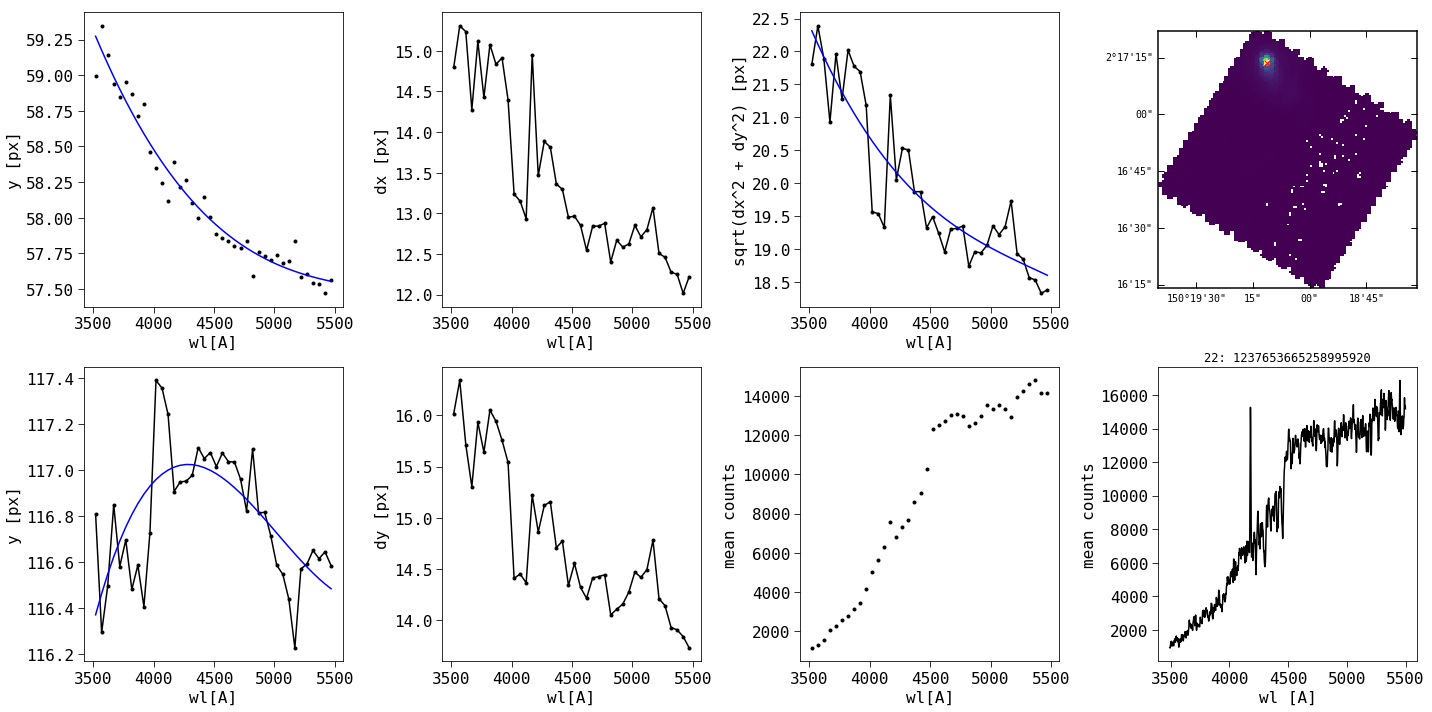

#############################################################
Extracting spectra from IFU 23 ../data/outcube_COSMOSC_023.fits.gz ...
#############################################################
###  1237653665258996313  ###
   Did not survive mag cut umag=25.4 gmag=22.86.
###  1237653665258996654  ###
   Did not survive mag cut umag=24.04 gmag=23.7.
###  1237653665258996658  ###
   Did not survive mag cut umag=24.67 gmag=24.3.
#############################################################
Extracting spectra from IFU 24 ../data/outcube_COSMOSC_024.fits.gz ...
#############################################################
###  1237653665258996275  ###
   Did not survive mag cut umag=22.58 gmag=22.06.
###  1237653665258996295  ###
   Did not survive mag cut umag=24.52 gmag=21.98.
#############################################################
Extracting spectra from IFU 25 ../data/outcube_COSMOSC_025.fits.gz ...
#############################################################
###  1237653665258

    Wrote ../specphot/extract/COSMOSC/1237653665258995727.txt.


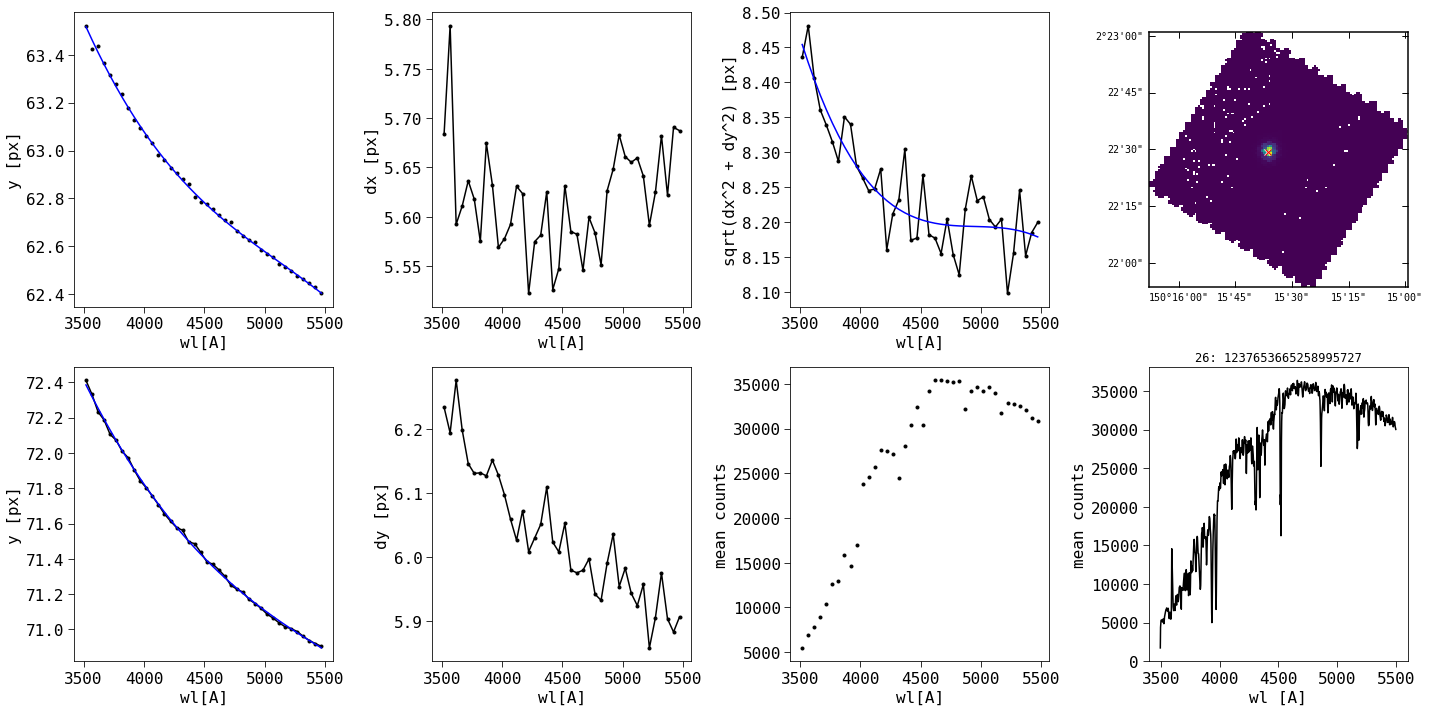

#############################################################
Extracting spectra from IFU 27 ../data/outcube_COSMOSC_027.fits.gz ...
#############################################################
###  1237653665258996174  ###
   Did not survive mag cut umag=23.41 gmag=22.15.
#############################################################
Extracting spectra from IFU 32 ../data/outcube_COSMOSC_032.fits.gz ...
#############################################################
###  1237653665258996309  ###
   Did not survive mag cut umag=23.95 gmag=23.95.
#############################################################
Extracting spectra from IFU 33 ../data/outcube_COSMOSC_033.fits.gz ...
#############################################################
###  1237653665258995883  ###
   Did survive mag cut umag=20.88 gmag=19.43.
is_star: sdss_id =  1237653665258995883
select p.objid,type FROM PhotoPrimary AS p WHERE type=6 AND p.objid = 1237653665258995883
   OK 1237653665258995883 is a star.
   M = 1007.

    Wrote ../specphot/extract/COSMOSC/1237653665258995883.txt.


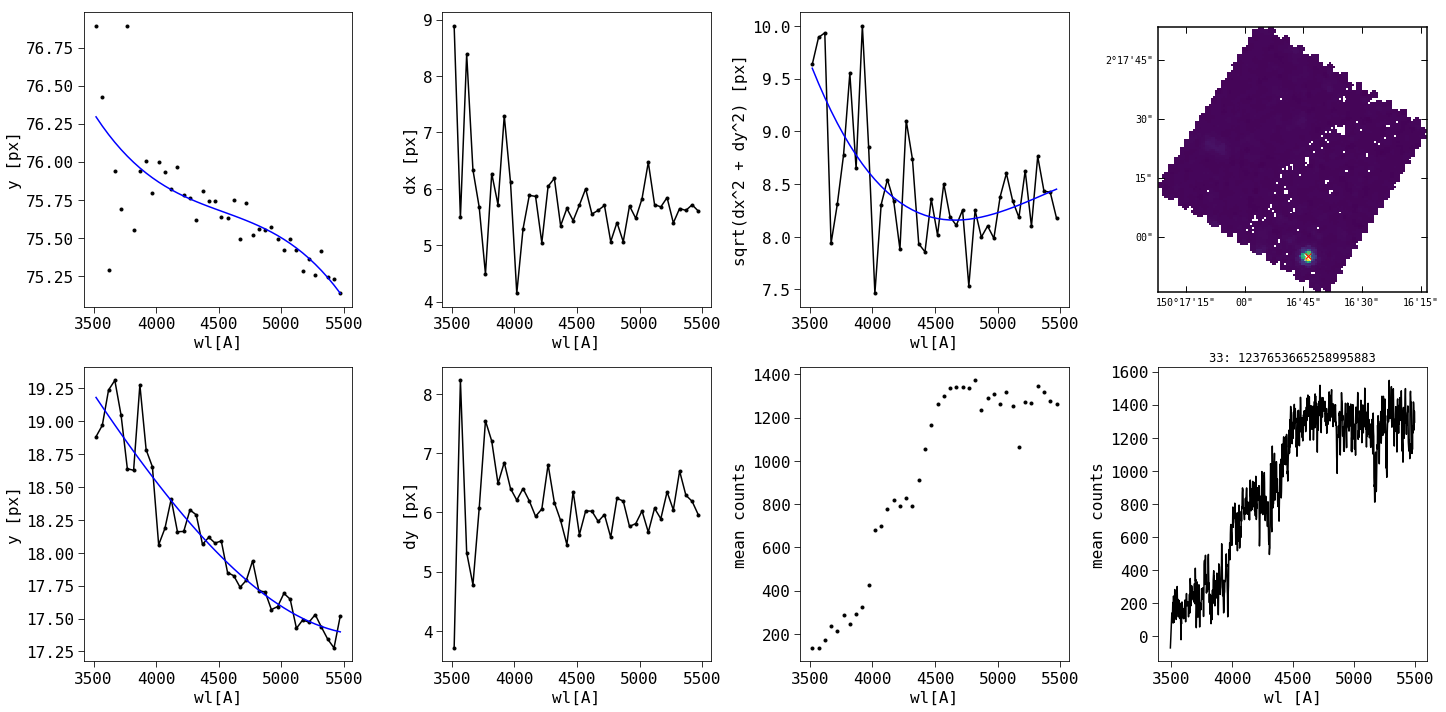

#############################################################
Extracting spectra from IFU 34 ../data/outcube_COSMOSC_034.fits.gz ...
#############################################################
###  1237653665258996006  ###
   Did not survive mag cut umag=22.47 gmag=20.39.
###  1237653665258996625  ###
   Did not survive mag cut umag=24.54 gmag=24.15.
#############################################################
Extracting spectra from IFU 35 ../data/outcube_COSMOSC_035.fits.gz ...
#############################################################
###  1237653665258930415  ###
   Did not survive mag cut umag=22.39 gmag=19.92.
#############################################################
Extracting spectra from IFU 36 ../data/outcube_COSMOSC_036.fits.gz ...
#############################################################
###  1237653665258930543  ###
   Did survive mag cut umag=20.59 gmag=20.54.
is_star: sdss_id =  1237653665258930543
select p.objid,type FROM PhotoPrimary AS p WHERE type=6 AND

    Wrote ../specphot/extract/COSMOSC/1237651753997303831.txt.


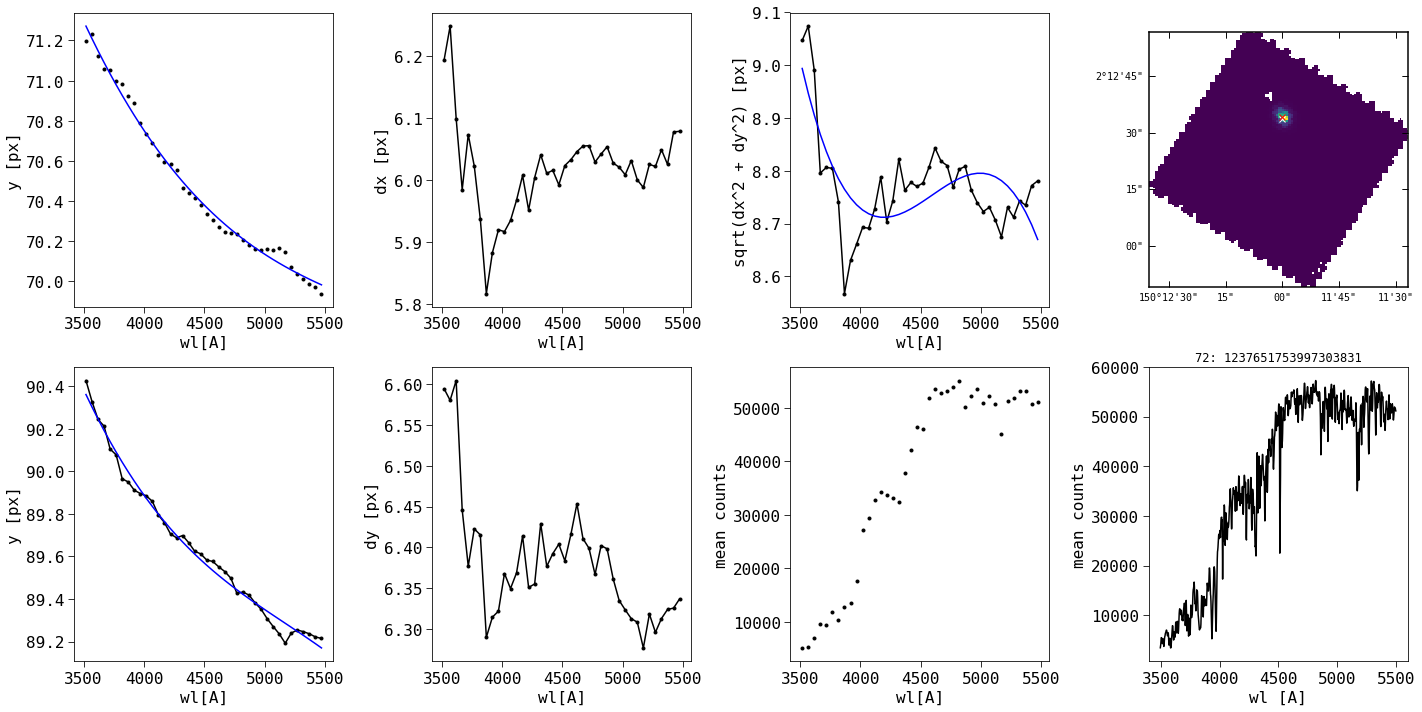

###  1237651753997304229  ###
   Did not survive mag cut umag=23.69 gmag=23.09.
#############################################################
Extracting spectra from IFU 73 ../data/outcube_COSMOSC_073.fits.gz ...
#############################################################
###  1237651753997304002  ###
   Did not survive mag cut umag=23.19 gmag=20.96.
#############################################################
Extracting spectra from IFU 74 ../data/outcube_COSMOSC_074.fits.gz ...
#############################################################
#############################################################
Extracting spectra from IFU 75 ../data/outcube_COSMOSC_075.fits.gz ...
#############################################################
#############################################################
Extracting spectra from IFU 76 ../data/outcube_COSMOSC_076.fits.gz ...
#############################################################
###  1237653665258930714  ###
   Did not survive mag cut uma

    Wrote ../specphot/extract/COSMOSC/1237651753997238523.txt.


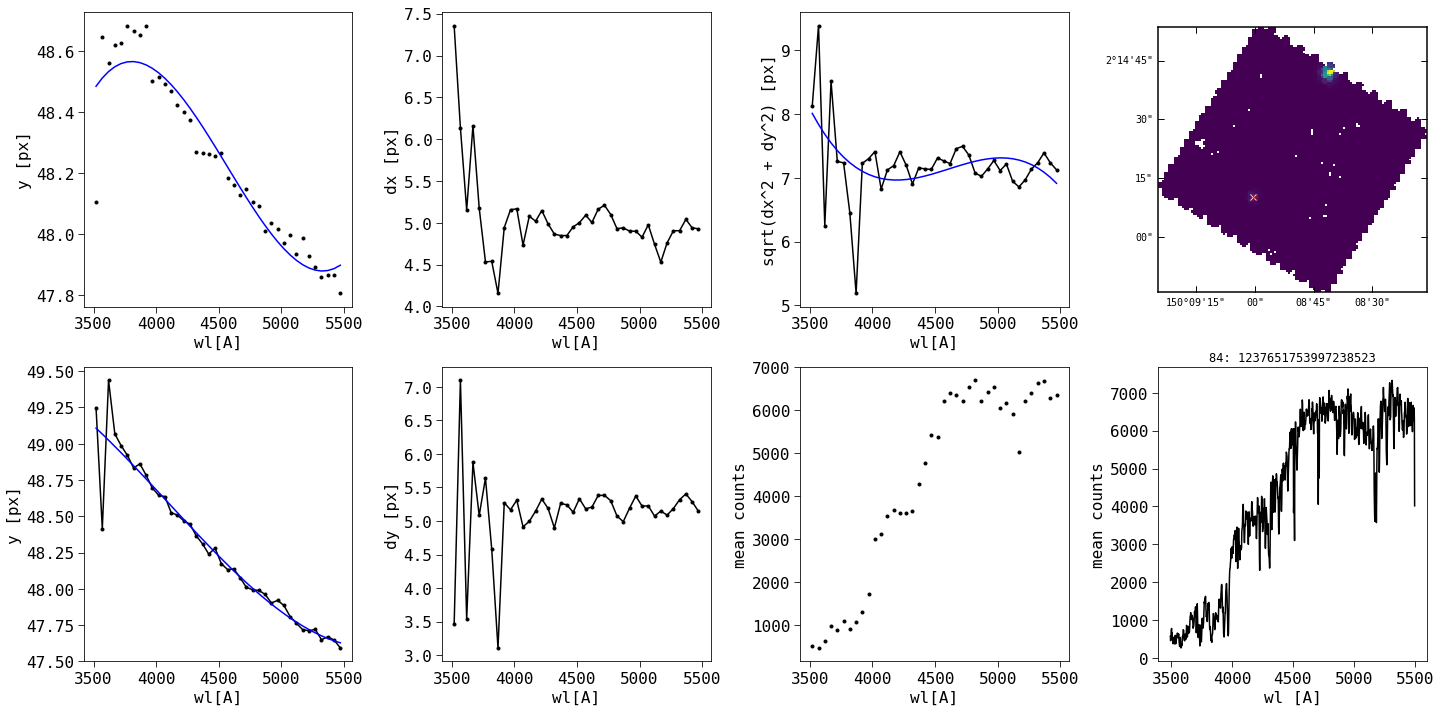

#############################################################
Extracting spectra from IFU 85 ../data/outcube_COSMOSC_085.fits.gz ...
#############################################################
###  1237651753997238509  ###
   Did not survive mag cut umag=21.81 gmag=19.56.
###  1237653665258930705  ###
   Did not survive mag cut umag=22.37 gmag=22.76.
#############################################################
Extracting spectra from IFU 86 ../data/outcube_COSMOSC_086.fits.gz ...
#############################################################
###  1237653665258930666  ###
   Did not survive mag cut umag=24.06 gmag=22.73.
###  1237653665258931074  ###
   Did not survive mag cut umag=24.66 gmag=23.45.
#############################################################
Extracting spectra from IFU 87 ../data/outcube_COSMOSC_087.fits.gz ...
#############################################################
#############################################################
Extracting spectra from IFU 93 ..

    Wrote ../specphot/extract/COSMOSC/1237651753997238500.txt.


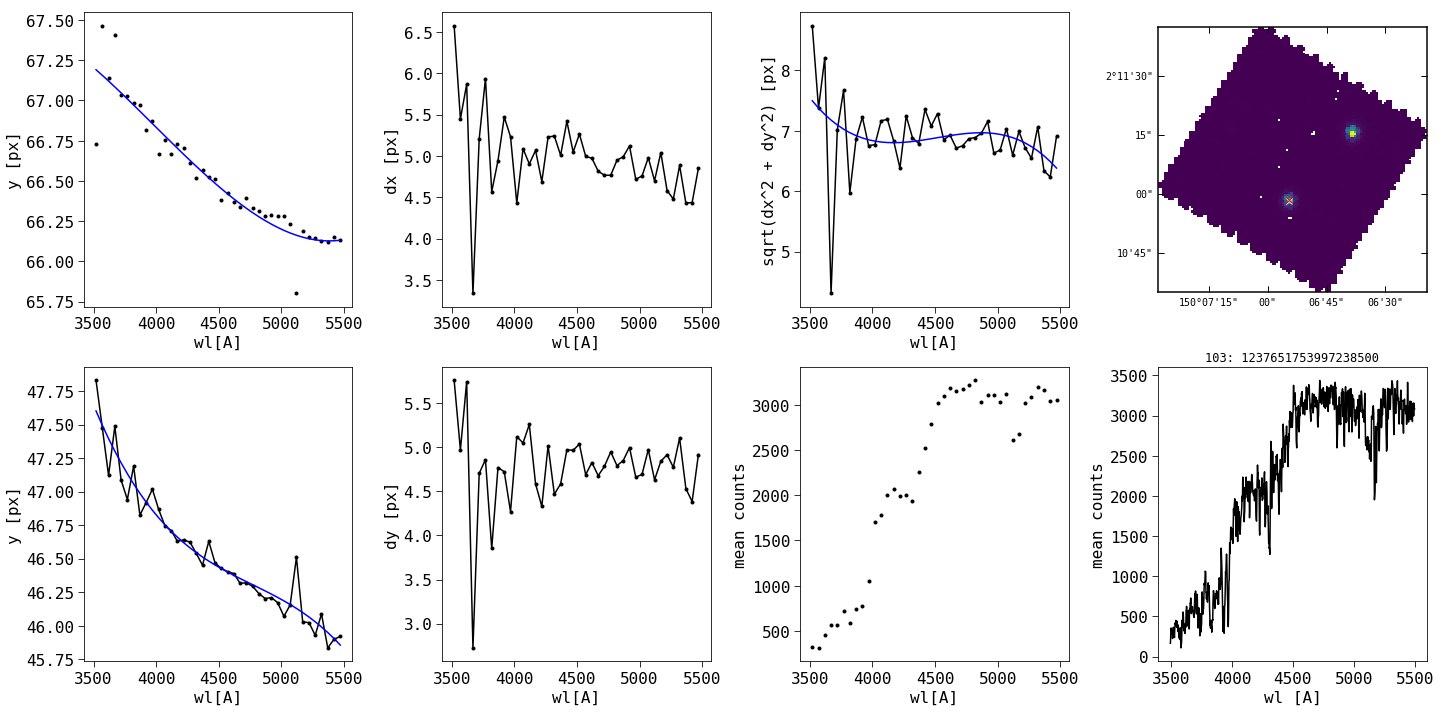

#############################################################
Extracting spectra from IFU 104 ../data/outcube_COSMOSC_104.fits.gz ...
#############################################################
###  1237651753997238483  ###
   Did survive mag cut umag=20.17 gmag=19.03.
is_star: sdss_id =  1237651753997238483
select p.objid,type FROM PhotoPrimary AS p WHERE type=6 AND p.objid = 1237651753997238483
   OK 1237651753997238483 is a star.
   M = 356.0
   x_com = 77.26826606585426, y_com = 4.55797099442185
   Discarding 1237651753997238483, for too low distance to next zero pixel with 1.3.
#############################################################
Extracting spectra from IFU 105 ../data/outcube_COSMOSC_105.fits.gz ...
#############################################################
#############################################################
Extracting spectra from IFU 106 ../data/outcube_COSMOSC_106.fits.gz ...
#############################################################
###  12376517539

In [12]:
all_adms = {}
all_spectra = {}
all_cogs = {}

_ifu_list = ifu_list["ifu"]
#_ifu_list = [74] # for testing
            
#_ifu_list = [33]
for ifu in _ifu_list:
    fcube = "../data/outcube_{}_{:03d}.fits.gz".format(field,ifu)

    print("#############################################################")
    print("Extracting spectra from IFU {} {} ...".format(ifu, fcube))
    print("#############################################################")
    t = ascii.read(fifustars)

    # read spectrum
    c = spectrum.readSpectrum(fcube)
    #mn = np.nanmedian( c.data, axis = 0 )

    t_inside = project(c,t) # find which stars fall inside the IFU cube footprint (not necessarily the IFU)
                            # also compute x,y coordinates

    spectra, adms, cogs = extract_all_in_ifu(c,t_inside, field, ifu)
    all_adms[ifu] = adms
    all_spectra[ifu] = spectra
    all_cogs[ifu] = cogs
    
    #break

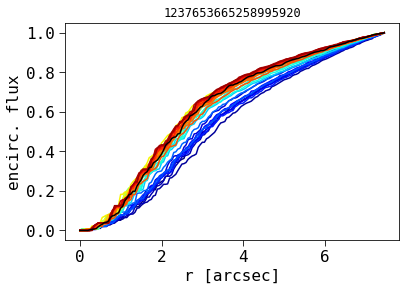

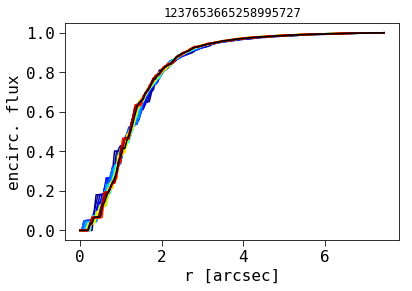

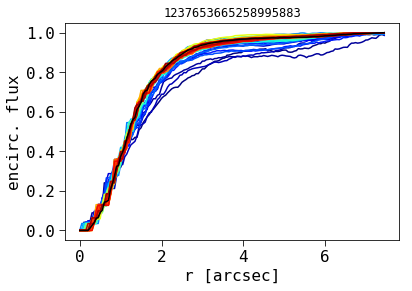

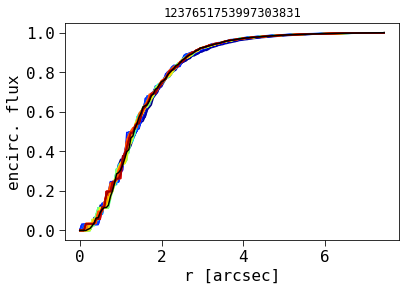

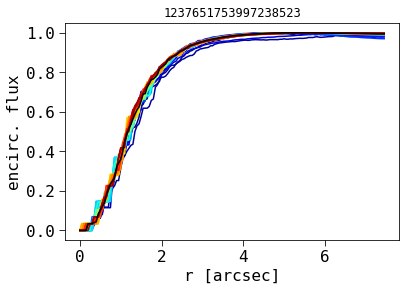

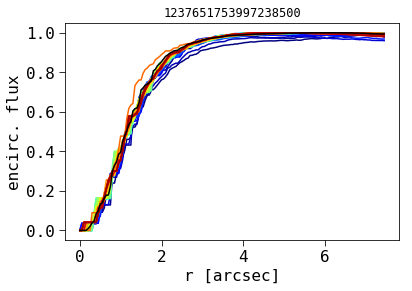

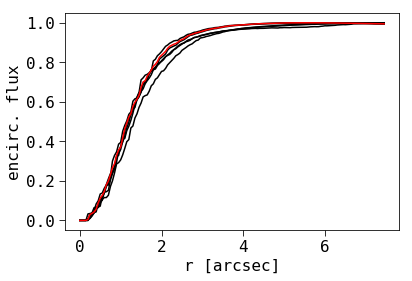

In [13]:
bad_sdss_ids = [1237653665258995920,1237651753997238521]
cm = plt.cm.jet
if True:
    for ifuid in all_cogs:
        #print(ifuid)
        cogs = all_cogs[ifuid]
        for sdssid in cogs:

            f = plt.figure()
            for i, cog in enumerate( cogs[sdssid] ):
                plt.plot(cog[:,0]*.5, cog[:,1]/np.max(cog[:,1]),c=cm(i/len(cogs[sdssid])))
            plt.xlabel("r [arcsec]")
            plt.ylabel("encirc. flux")


            mcog = np.median( cogs[sdssid], axis=0 )
            plt.plot(cog[:,0]*.5, mcog[:,1]/np.max(mcog[:,1]), c='k' )
            plt.title(sdssid)
        
f = plt.figure()
supercog = [mcog]
for ifuid in all_cogs:
    #print(ifuid)
    cogs = all_cogs[ifuid]
    for sdssid in cogs:
        if sdssid in bad_sdss_ids:
            continue
        mcog = np.median( cogs[sdssid], axis=0 )
        supercog.append(mcog)
        plt.plot(cog[:,0]*.5, mcog[:,1]/np.max(mcog[:,1]), c='k' )
        #plt.title(sdssid)
        
supercog = np.array(supercog)
msupercog = np.median(supercog,axis=0)
plt.plot(cog[:,0]*.5, msupercog[:,1]/np.max(msupercog[:,1]), c='r' )
plt.xlabel("r [arcsec]")
plt.ylabel("encirc. flux")

t = Table( [cog[:,0]*.5, msupercog[:,1]/np.max(msupercog[:,1])], names=["r","EE"])
t.write("../specphot/cog_{}.txt".format(field), format="ascii.fixed_width")

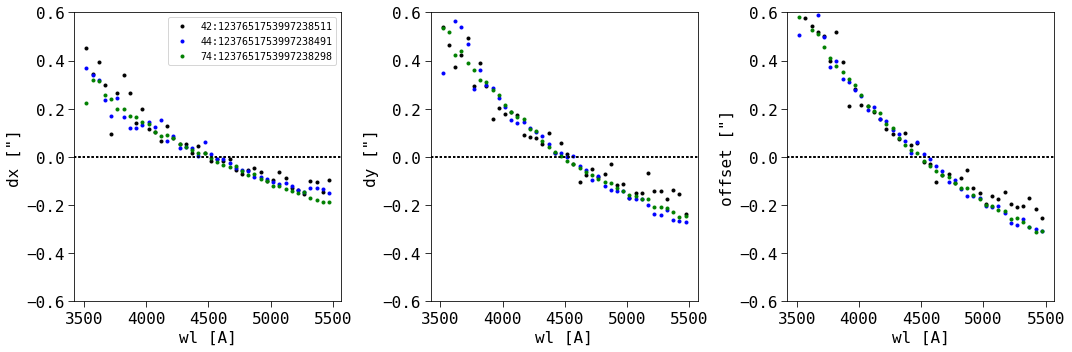

In [86]:
w = wcs.WCS(c.hdu.header)
w.dropaxis(2)
ps = np.abs(w.wcs_pix2world(0,0,0,0)[1] - w.wcs_pix2world(0,1,0,0)[1])*3600.

f = plt.figure(figsize=[15,5])
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)
for ifu in all_adms:
    for id in all_adms[ifu]:
        all_adms[ifu][id]
        ww = all_adms[ifu][id].centroids[:,0]
        xx = all_adms[ifu][id].centroids[:,2]
        yy = all_adms[ifu][id].centroids[:,3]
        mx = all_adms[ifu][id].xofw(4500.)
        my = all_adms[ifu][id].yofw(4500.)
        
        ax1.plot(ww,(xx-mx) * ps,'.', label="{}:{}".format(ifu,id))
        ax1.set_ylim([-.6,.6])
        ax1.set_xlabel("wl [A]")
        ax1.set_ylabel("dx [\"]")
        ax1.axhline(0.,ls=':')
        
        ax2.plot(ww,(yy-my) * ps,'.')
        ax2.set_ylim([-.6,.6])
        ax2.set_ylabel("dy [\"]")
        ax2.set_xlabel("wl [A]")
        ax2.axhline(0.,ls=':')
         
        ax3.plot(ww,np.sqrt((xx-mx)**2. +  (yy-my)**2.) * np.sign((xx-mx))* ps,'.')
        ax3.set_ylim([-.6,.6])
        ax3.set_ylabel("offset [\"]")
        ax3.set_xlabel("wl [A]")
        ax3.axhline(0.,ls=':')
        
ax1.legend()
f.tight_layout()

# Now compute calibration (= response curve)...

In [87]:
from astropy.io import ascii
import numpy as np
from astropy import table
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
%matplotlib inline

In [88]:
def read_data(fspec, fsed):
    # read data
    spec = ascii.read(fspec, format='fixed_width')
    sed = ascii.read(fsed)
    sed = sed[1:]
    return spec, sed

In [89]:
def compute_cal(spec, sed, fsed, PLOT=True):
    dw = np.mean( np.diff(sed["col1"][1:]) )
    spec_binned = []
    for w in sed["col1"]:
        ii  = spec["wl"] >= w-dw/2.
        ii *= spec["wl"] <  w+dw/2.
        spec_binned.append( np.mean(spec["count"][ii]) )
    spec_binned = np.array(spec_binned)


    cal = sed["col2"]/spec_binned
    cal_interp = interp1d(sed["col1"], cal, kind='cubic', bounds_error=False)
    
    if PLOT:
        f = np.mean(cal)
        fig = plt.figure(figsize=[15,5])
        plt.title("Foo")

        plt.subplot(131)
        plt.plot(sed["col1"],sed["col2"],'x')
        plt.plot(spec["wl"],spec["count"]*f,'b-', alpha=.5)
        plt.plot(sed["col1"],spec_binned*f,'bo')
        plt.ylabel("erg/s/cm^2/A")
        plt.xlabel("wavelength [A]")

        ax2 = plt.subplot(132)
        plt.plot(sed["col1"],cal,'s')
        plt.plot(sed["col1"],cal_interp(sed["col1"]),'k-')
        plt.ylabel("erg/s/cm^2/A")
        plt.xlabel("wavelength [A]")
        plt.text(.5,1.05,fsed, transform=ax2.transAxes,ha='center',va='bottom')


        plt.subplot(133)
        plt.plot(sed["col1"],spec_binned*cal,'bo')
        plt.plot(sed["col1"],sed["col2"],'kx')
        plt.plot(spec["wl"],spec["count"]*cal_interp(spec["wl"]),'b-', alpha=.5)
        plt.ylabel("erg/s/cm^2/A")
        plt.xlabel("wavelength [A]")
        fig.tight_layout()
        plt.show()
        
        return sed["col1"], cal, spec_binned


In [90]:
def do_cal(field, sdss_id):
    fsed = "../specphot/seds/{}/000001_{}.txt".format(field, sdss_id)
    fspec = "../specphot/extract/{}/{}.txt".format(field, sdss_id)
    fcalout = "../specphot/extract/{}/{}_cal.txt".format(field, sdss_id)

    # read data
    spec, sed = read_data(fspec, fsed)

    #compute calibration
    ww, cal, spec_binned = compute_cal(spec, sed, fsed)

    # write calibration
    tcal = table.Table(data=[ww, cal, spec_binned], dtype=[float,float, float], names=["wl[A]","cal[erg/s/cm^2/A/cnt]","counts"])
    tcal.write(fcalout, overwrite=True, format="ascii.fixed_width")
    print("Wrote {}".format(fcalout))
    

In [91]:
for ifu in all_spectra:
    for id in all_spectra[ifu]:
        !ls ../specphot/extract/$field/$id*

../specphot/extract/COSMOSA/1237651753997238511.txt
../specphot/extract/COSMOSA/1237651753997238491.txt
../specphot/extract/COSMOSA/1237651753997238491_cal.txt
../specphot/extract/COSMOSA/1237651753997238298.txt
../specphot/extract/COSMOSA/1237651753997238298_cal.txt


In [92]:
# manually flag bad objects (galaxies that were accidently labelled stars by sdss or bad extractions)
badids = bad_sdss_ids + [1237653665258995920, 1237651753997304229] 

In [93]:
import glob

# Here we must select which stars we actually want to use for the claibration
cal_star_ids = []
for ifu in all_spectra:
    for sdss_id in all_spectra[ifu]:
            fs   = "../specphot/extract/{}/{}.txt".format(field,sdss_id)
            ffs = glob.glob(fs)
            fsed = "../specphot/seds/{}/000001_{}.txt".format(field,sdss_id)
            ffsed = glob.glob(fsed)
            #print(ffs)
            #print(ffsed)
            if len(ffs) == 1 and len(ffsed) == 1 and not sdss_id in badids:
                cal_star_ids.append(sdss_id) 

In [94]:
sdss_id

1237651753997238298

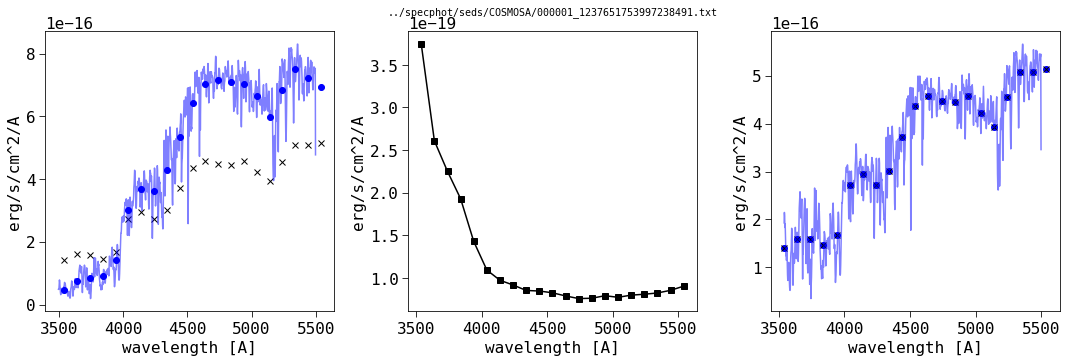

Wrote ../specphot/extract/COSMOSA/1237651753997238491_cal.txt


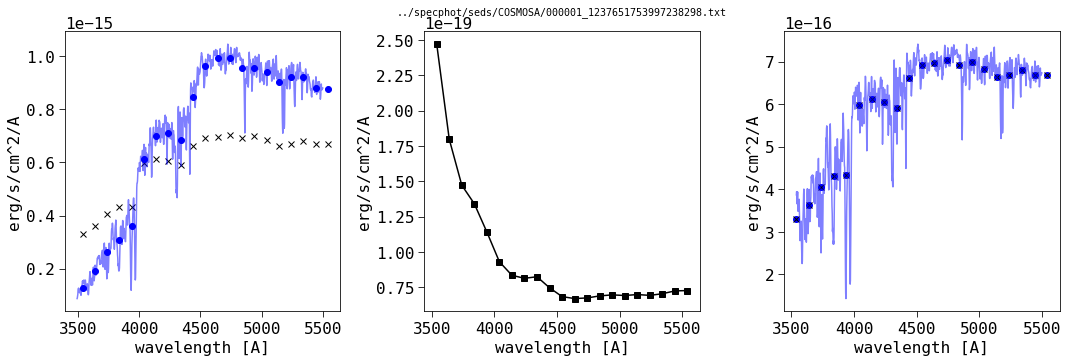

Wrote ../specphot/extract/COSMOSA/1237651753997238298_cal.txt


In [95]:
# run the clibration
for sdss_id in cal_star_ids:
    do_cal(field, sdss_id)

[0.77994443 0.49709267 0.47667451 0.36036897 0.17546156 0.09910348
 0.08412219 0.06324542 0.01713971 0.06115581 0.08654711 0.0725445
 0.05068809 0.04435069 0.05803423 0.04948368 0.06080015 0.07086821
 0.07274501 0.07951574 0.10809765]


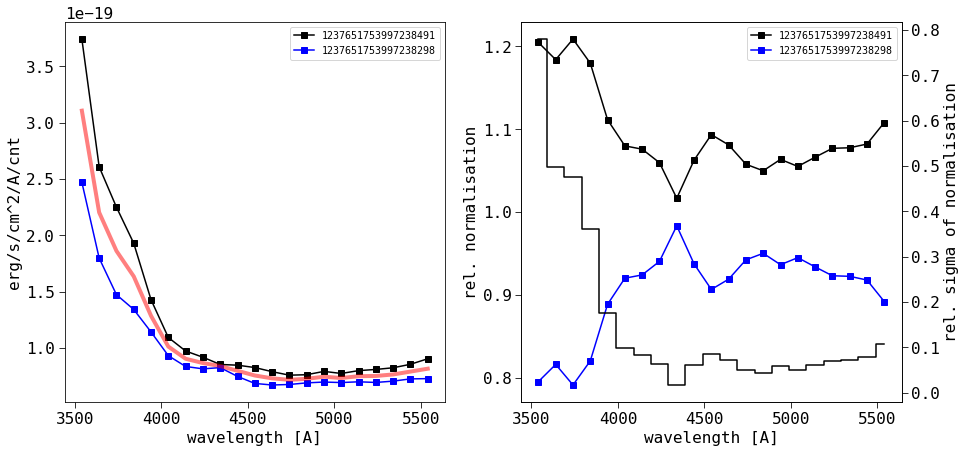

In [96]:
# Visualize the different response curves
# as well as their mean and their scatter
f = plt.figure(figsize=[15,7])

ax1 = plt.subplot(121)
all_cal = []
all_cnt = []
for cal_star_id in cal_star_ids:
    fcalout = "../specphot/extract/{}/{}_cal.txt".format(field, cal_star_id)
    tcal = ascii.read(fcalout, format='fixed_width')
    all_cal.append(tcal['cal[erg/s/cm^2/A/cnt]'])
    all_cnt = [tcal['counts']]
    plt.plot(tcal['wl[A]'],tcal['cal[erg/s/cm^2/A/cnt]'],'s-', label=cal_star_id)
plt.legend()
plt.ylabel("erg/s/cm^2/A/cnt")
plt.xlabel("wavelength [A]")


ax2 = plt.subplot(122)
all_cal = np.array(all_cal)
all_cnt = np.array(all_cnt)
mall_cal = np.mean(all_cal, axis=0)

for cal_star_id in cal_star_ids:
    fcalout = "../specphot/extract/{}/{}_cal.txt".format(field, cal_star_id)
    tcal = ascii.read(fcalout, format='fixed_width')
    plt.plot(tcal['wl[A]'],tcal['cal[erg/s/cm^2/A/cnt]']/mall_cal,'s-', label=cal_star_id)
plt.legend()
#plt.ylabel("erg/s/cm^2/cnt")
plt.xlabel("wavelength [A]")
plt.ylabel("rel. normalisation")
plt.twinx()

# compute average calibration
ss = []
mm = []
wmm = [] # weighted mean
ws = []
ww = tcal['wl[A]']
for i,w in enumerate(ww):
    s = np.std( all_cal[:,i] )
    m = np.mean( all_cal[:,i] )
    wm = np.mean( all_cal[:,i]*all_cnt[:,i] )/np.sum(all_cnt[:,i])
    #w = (wlmax+wlmin)/2.
    ss.append(s)
    ws.append(w)
    mm.append(m)
    wmm.append(wm) # form weighted mean
plt.plot(ww,ss/m,drawstyle='steps-mid')
plt.ylabel("rel. sigma of normalisation")

ax1.plot(ww,wmm,'r-', lw=4, alpha=.5)


print(ss/m)

In [97]:
# save the computed mean claibration
tmeancal = table.Table(data=[ww, mm], names=['wl[A]','cal[erg/s/cm^2/A/cnt]'], dtype=[float,float])
tmeancal.write("../specphot/mean_cal_{}.txt".format(field), format='ascii.fixed_width')

# check that application of flux calibration to cube worked well

In [101]:
def apply_cal(fcubein, ftcal, fcubeout):
    print("Applying calibration to {}...".format(fcubein) )

    tcal = ascii.read(ftcal, format="fixed_width")

    #cal_interp = interp1d(tcal["wl[A]"], tcal["cal[erg/s/cm^2/A/cnt]"], kind='cubic', bounds_error=False, fill_value="extrapolate")
    cal_interp = interp1d(tcal["wl[A]"], tcal["cal[erg/s/cm^2/A/cnt]"], bounds_error=False, fill_value="extrapolate")

    s = spectrum.readSpectrum(fcubein)

    ww = s.grid()
    for i,w in enumerate(ww):
        s.data[i] = s.data[i] * cal_interp(w) #* 1e17

    h = fits.PrimaryHDU(data=s.data, header=s.hdu.header)
    #h.header['BUNITS'] = 'erg'
    h.writeto(fcubeout, overwrite=True)

In [102]:
# all we do is to muyltiply each pixel with the response curve
import spectrum
from scipy.interpolate import interp1d
from astropy.io import ascii, fits


for ifu in all_spectra:
    for sdss_id in all_spectra[ifu]:
        if sdss_id in cal_star_ids:
            
            fcubein = "../data/outcube_{}_{:03d}.fits.gz".format(field, ifu)
            ftcal = "../specphot/mean_cal_{}.txt".format(field)
            fcubeout = "../data/coutcube_{}_{:03d}.fits.gz".format(field, ifu)
            
            apply_cal(fcubein, ftcal, fcubeout)

Applying calibration to ../data/outcube_COSMOSA_044.fits.gz...
Applying calibration to ../data/outcube_COSMOSA_074.fits.gz...


Extracting spectra from IFU 044 ../data/coutcube_COSMOSA_044.fits.gz ...
###  1237651753997239323  ###
   Did not survive mag cut umag=24.35 gmag=23.74.
###  1237651753997238491  ###
   Did survive mag cut umag=19.68 gmag=17.64.
is_star: sdss_id =  1237651753997238491
select p.objid,type FROM PhotoPrimary AS p WHERE type=6 AND p.objid = 1237651753997238491
   OK 1237651753997238491 is a star.
   M = 0.0
   x_com = 92.27735575011573, y_com = 114.90635509040996
   Distance of 1237651753997238491 to next zero pixel ok with 12.5.
   Mean counts of 1237651753997238491 with 3.181351888971713e-16 cts is sufficient to continue.


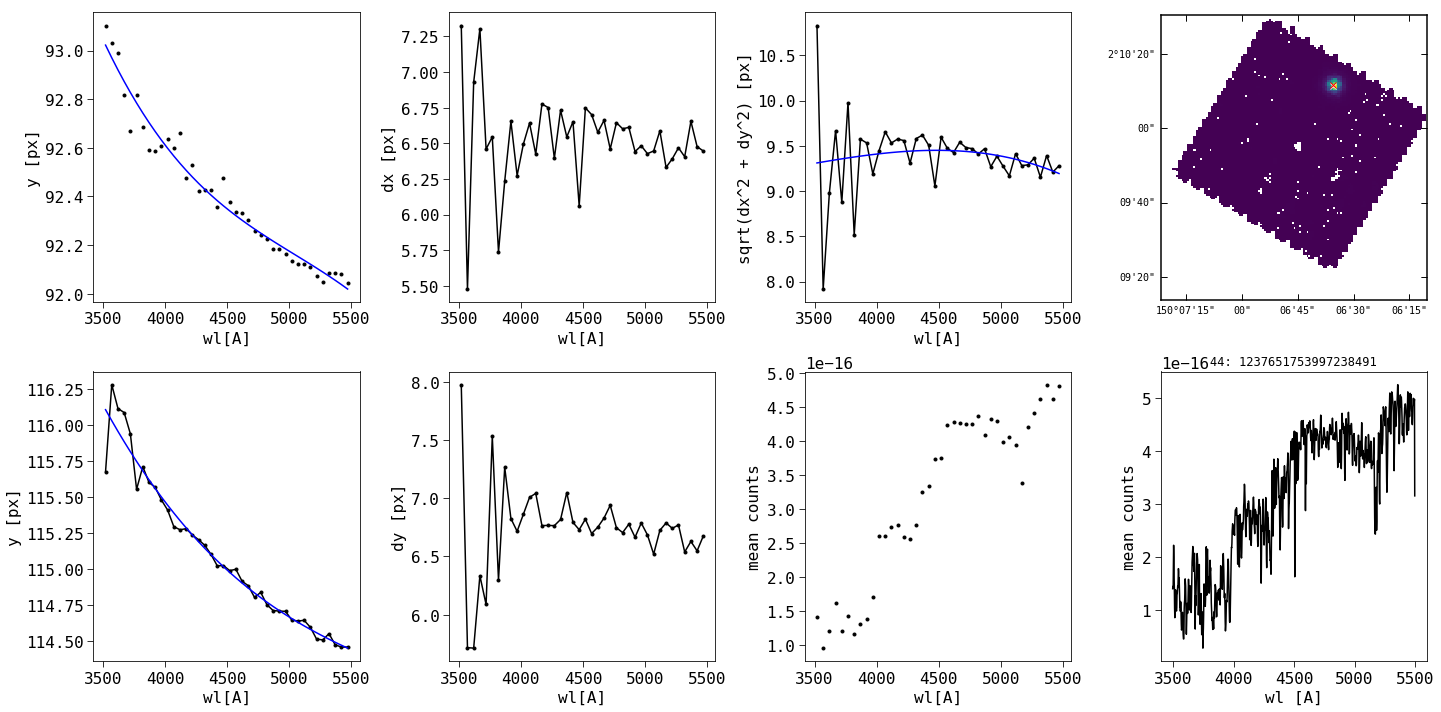

Extracting spectra from IFU 074 ../data/coutcube_COSMOSA_074.fits.gz ...
###  1237651753997238734  ###
   Did not survive mag cut umag=23.79 gmag=21.04.
###  1237651753997238739  ###
   Did not survive mag cut umag=24.42 gmag=23.49.
###  1237651753997238298  ###
   Did survive mag cut umag=18.39 gmag=17.1.
is_star: sdss_id =  1237651753997238298
select p.objid,type FROM PhotoPrimary AS p WHERE type=6 AND p.objid = 1237651753997238298
   OK 1237651753997238298 is a star.
   M = 0.0
   x_com = 88.30769712367422, y_com = 41.76947459614899
   Distance of 1237651753997238298 to next zero pixel ok with 16.6.
   Mean counts of 1237651753997238298 with 6.517362101774421e-16 cts is sufficient to continue.


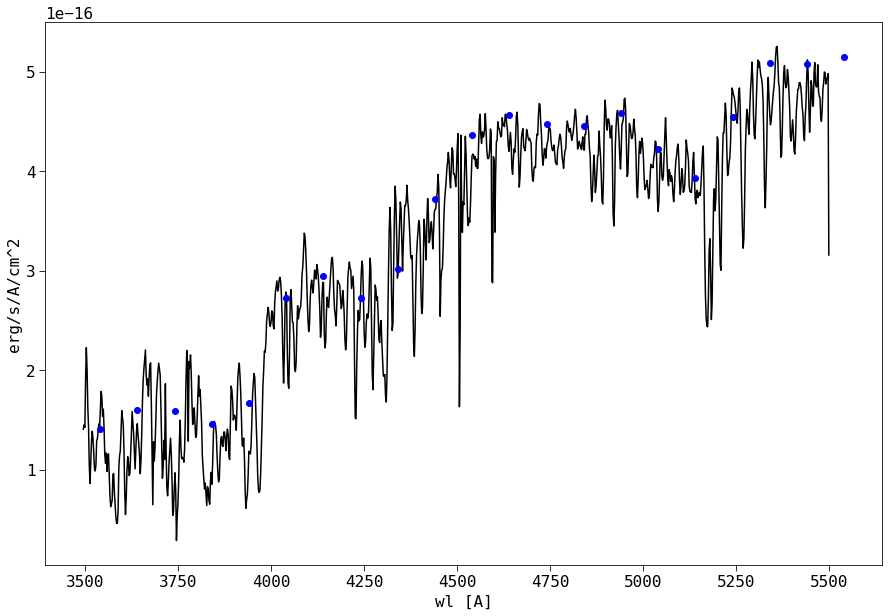

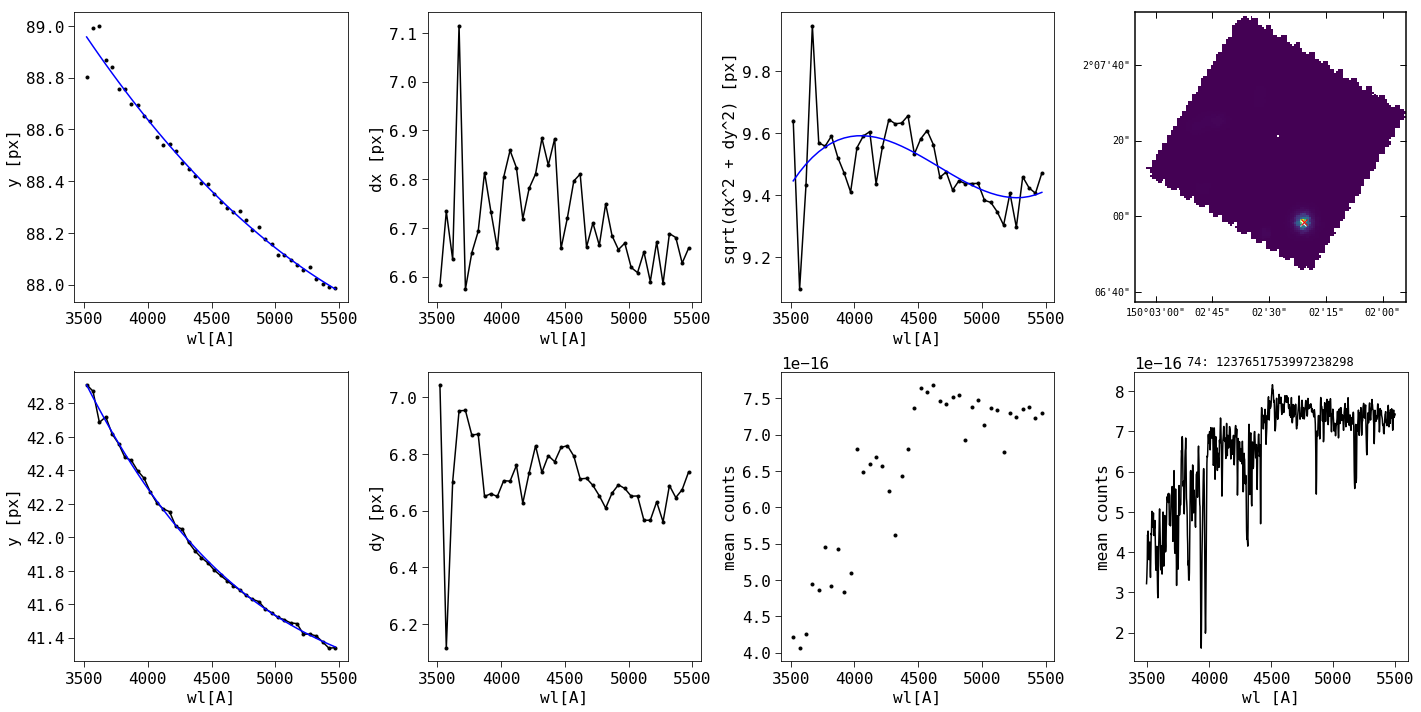

###  1237651753997238761  ###
   Did not survive mag cut umag=22.08 gmag=20.27.
###  1237651753997238760  ###
   Did not survive mag cut umag=22.14 gmag=20.27.
###  1237651753997238757  ###
   Did not survive mag cut umag=22.12 gmag=21.99.


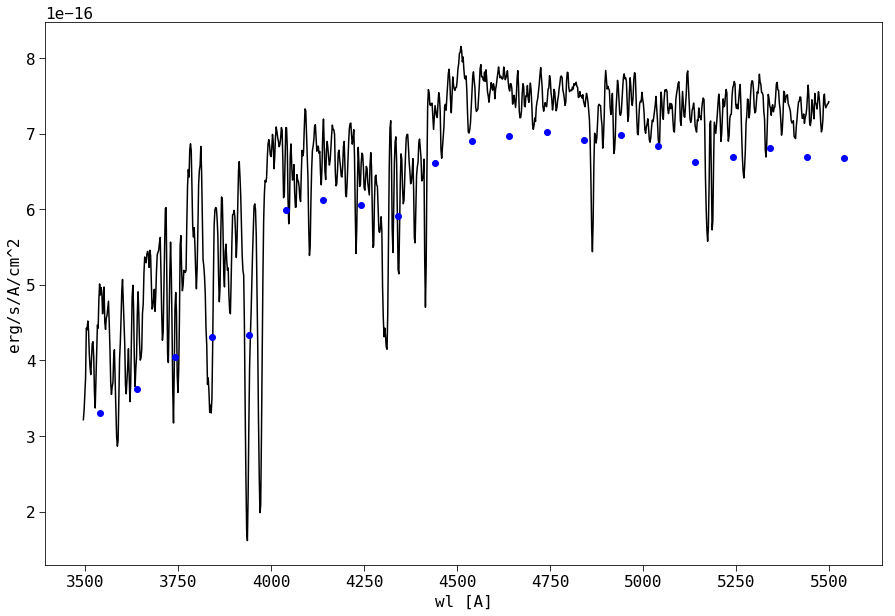

In [104]:
# here we extract spectra for the calibration stars
# and overplot the SEDs
for ifu in all_spectra:
    for sdss_id in all_spectra[ifu]:
        if sdss_id in cal_star_ids:
            fcube = "../data/coutcube_{}_{:03d}.fits.gz".format(field, ifu)

            print("Extracting spectra from IFU {:03d} {} ...".format(ifu, fcube))
            t = ascii.read(fifustars)

            # read spectrum
            c = spectrum.readSpectrum(fcube)
            

            t_inside = project(c, t)
            #ii = t_inside["col2"] == str(star_id)


            spectra, adms, __ = extract_all_in_ifu(c, t_inside, field, ifu, threshold=0.,SAVESPEC=False)

            
            # and plot the spectra
            ww,ff  = spectra[sdss_id]

            fsed = "../specphot/seds/{}/000001_{}.txt".format(field,sdss_id)
            sed = ascii.read(fsed)
            sed = sed[1:]


            f = plt.figure(figsize=[15,10])
            ax2 = plt.subplot()

            plt.plot( ww,ff  ,'-')
            plt.plot( sed["col1"], sed["col2"] ,'o')

            ax2.set_xlabel("wl [A]")
            ax2.set_ylabel("erg/s/A/cm^2")

# now take the one actually existing SDSS spectrum 3154-54821-0160

In [106]:
ifu = 73

fcubein = "../data/outcube_{}_{:03d}.fits.gz".format(field, ifu)
ftcal = "../specphot/mean_cal_{}.txt".format(field)
fcubeout = "../data/coutcube_{}_{:03d}.fits.gz".format(field, ifu)

apply_cal(fcubein, ftcal, fcubeout)

Applying calibration to ../data/outcube_COSMOSA_073.fits.gz...


In [107]:

fcube = "../data/coutcube_{}_{:03d}.fits.gz".format(field, ifu)


print("Extracting spectra from IFU {} {} ...".format(ifu, fcube))

# read spectrum
c = spectrum.readSpectrum(fcube)
xx,yy = np.arange(c.data.shape[2]), np.arange(c.data.shape[1])
XX,YY = np.meshgrid(xx,yy)

# take median collapsed cube a slice
sl = np.nanmedian( c.data, axis = 0 )
spectra = {}

xc = 59.230769
yc = 125.0863

# take initial values for position 
dd = np.sqrt( (XX-xc)**2. + (YY-yc)**2. )

jj = dd < 10.

# compute moments
M = np.nansum(sl[jj])
x_com = np.nansum(sl[jj]*XX[jj])/M
y_com = np.nansum(sl[jj]*YY[jj])/M

dx = np.sqrt( np.nansum( sl[jj] * (XX[jj] - x_com)**2. ) / M ) * 2.35 # FWHM
dy = np.sqrt( np.nansum( sl[jj] * (YY[jj] - y_com)**2. ) / M ) * 2.35 # FWHM
size = np.sqrt(dx**2. + dy**2.)
#print("   ", r['col2'], r["col3"], r["col4"], r['x'], r['y'], x_com, y_com, dx, dy, size )

# recompute
dd2 = np.sqrt( (XX-x_com)**2. + (YY-y_com)**2. ) 

# I *think* this is essentially a Kron aperture
#kk = dd2 <= 2. * size
# Make it larger to get more
#kk = dd2 <= 3. * size
kk = dd2 <= 1. * size

#ww,ss =  extract(c,kk)

ww, ss =  extract(c, x_com, y_com, size, XX, YY, apfactor=3.)

Extracting spectra from IFU 73 ../data/coutcube_COSMOSA_073.fits.gz ...


In [108]:
from astropy.table import Table

sdss = Table.read("../specphot/spec-3154-54821-0160.fits")

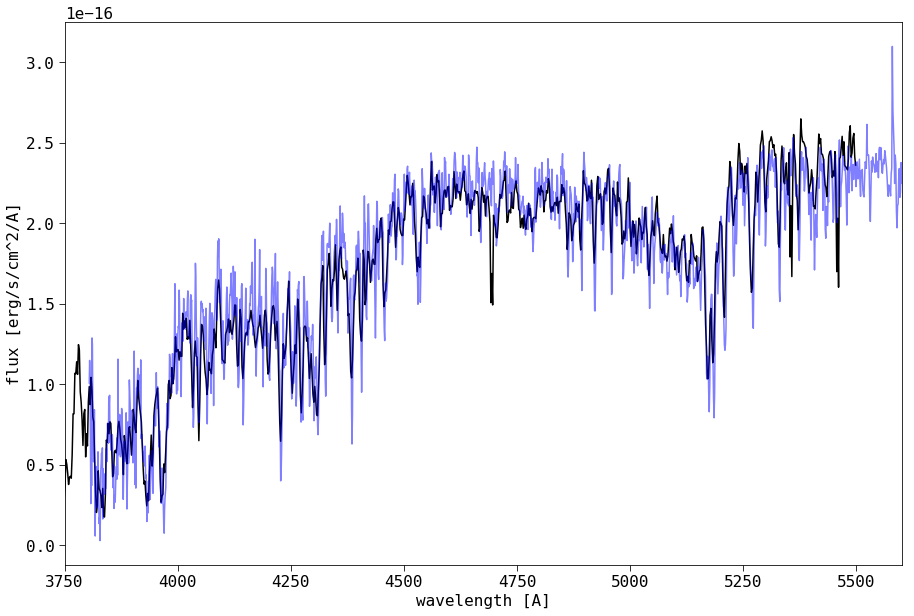

In [109]:
import numpy as np
f = plt.figure(figsize=[15,10])
plt.plot(ww,ss, label='HETDEX')

plt.plot( 10.**( sdss['loglam'] ), sdss['flux']*1e-17, label='sdss', alpha=.5)

plt.xlim([3750.,5600.])

plt.ylabel("flux [erg/s/cm^2/A]")
plt.xlabel("wavelength [A]")

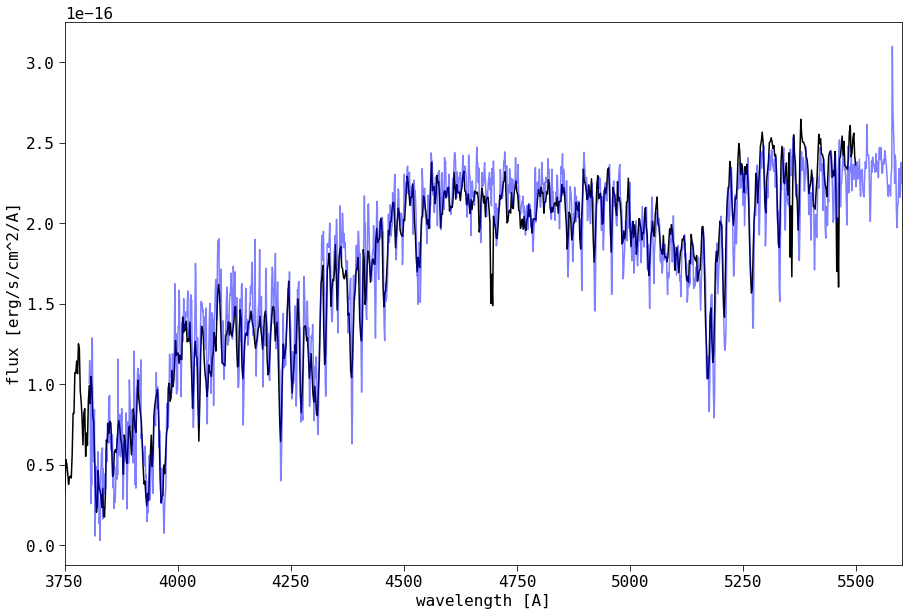

In [709]:
import numpy as np
f = plt.figure(figsize=[15,10])
plt.plot(ww,ss, label='HETDEX')

plt.plot( 10.**( sdss['loglam'] ), sdss['flux']*1e-17, label='sdss', alpha=.5)

plt.xlim([3750.,5600.])

plt.ylabel("flux [erg/s/cm^2/A]")
plt.xlabel("wavelength [A]")

# compare calibrations

In [25]:
fcals = !ls ../specphot/mean_cal*

../specphot/mean_cal_COSMOSA.txt
../specphot/mean_cal_COSMOSB.txt
../specphot/mean_cal_COSMOSC.txt
../specphot/mean_cal_COSMOSD.txt


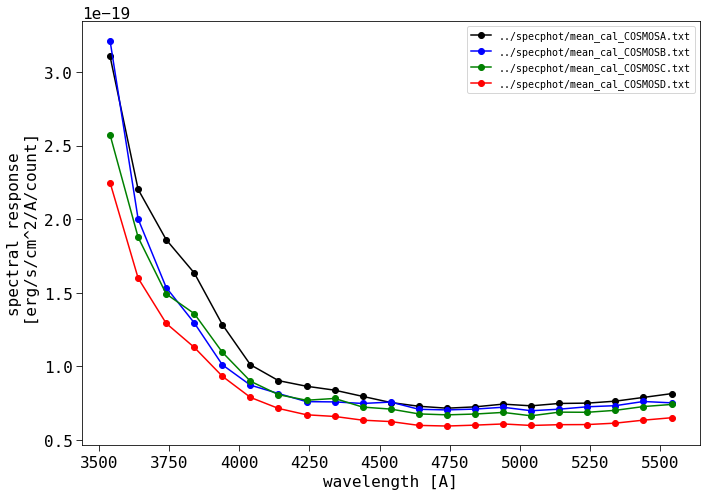

In [26]:
fig = plt.figure(figsize=[10,7])
for f in fcals:
    print(f)
    tcal = ascii.read(f, format="fixed_width")
    plt.plot( tcal["wl[A]"], tcal["cal[erg/s/cm^2/A/cnt]"] ,'o-', label=f)
 

plt.ylabel("spectral response\n [erg/s/cm^2/A/count]")
plt.xlabel("wavelength [A]")
plt.legend()
fig.tight_layout()

In [69]:
fcogs = !ls ../specphot/cog_COSMOS?.txt

../specphot/cog_COSMOSA.txt
../specphot/cog_COSMOSB.txt
../specphot/cog_COSMOSC.txt
../specphot/cog_COSMOSD.txt


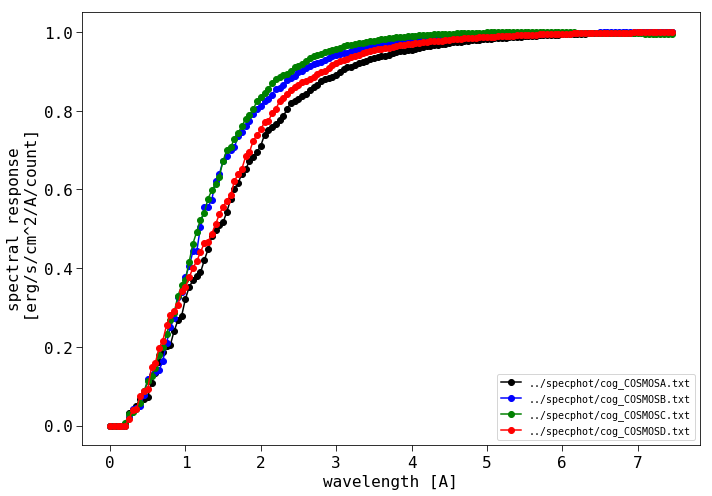

In [71]:
fig = plt.figure(figsize=[10,7])
for f in fcogs:
    print(f)
    tcal = ascii.read(f, format="fixed_width")
    plt.plot( tcal["r"], tcal["EE"] ,'o-', label=f)
 

plt.ylabel("spectral response\n [erg/s/cm^2/A/count]")
plt.xlabel("wavelength [A]")
plt.legend()
fig.tight_layout()